#### Frequencies

+ Alias    Description
+ B        business day frequency
+ C        custom business day frequency
+ D        calendar day frequency
+ W        weekly frequency
+ M        month end frequency
+ SM       semi-month end frequency (15th and end of month)
+ BM       business month end frequency
+ CBM      custom business month end frequency
+ MS       month start frequency
+ SMS      semi-month start frequency (1st and 15th)
+ BMS      business month start frequency
+ CBMS     custom business month start frequency
+ Q        quarter end frequency
+ BQ       business quarter end frequency
+ QS       quarter start frequency
+ BQS      business quarter start frequency
+ A, Y     year end frequency
+ BA, BY   business year end frequency
+ AS, YS   year start frequency
+ BAS, BYS business year start frequency
+ BH       business hour frequency
+ H        hourly frequency
+ T, min   minutely frequency
+ S        secondly frequency
+ L, ms    milliseconds
+ U, us    microseconds
+ N        nanoseconds

In [1]:
import pandas as pd
import numpy as np

In [2]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

### Read the data

In [3]:
data = pd.read_csv('airline-passengers.csv', index_col='Month', parse_dates=True)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [5]:
data.index.freq='MS'

In [6]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


### Visualize the data

In [8]:
import matplotlib.pyplot as plt

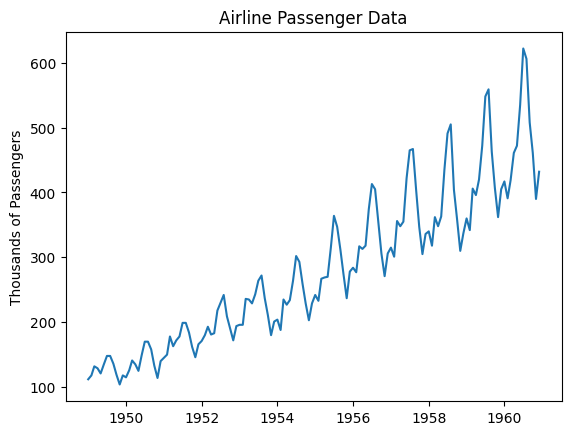

In [9]:
plt.title('Airline Passenger Data')
plt.ylabel('Thousands of Passengers')
plt.plot(data)
plt.show()

### ETS decomposition of the data

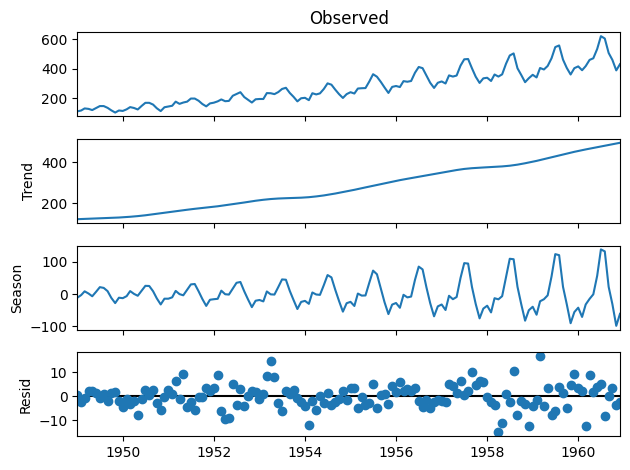

In [10]:
df = STL(data).fit()
df.plot()
plt.show()

### Split data into train and test

In [11]:
train_len = int(len(data)*0.75)
test_len = int(len(data)*.25)

train_len, test_len

(108, 36)

In [12]:
train_data = data[:108]
test_data = data[108:]
#test_data

### Visualise the data

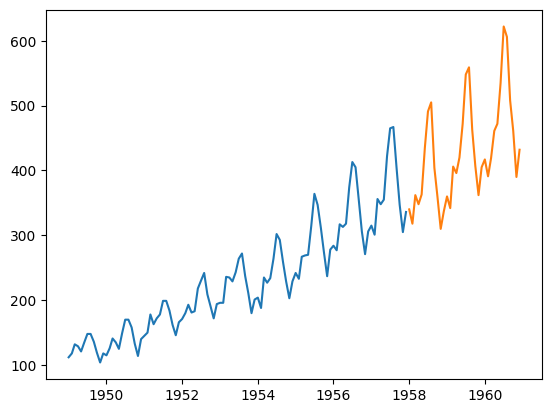

In [13]:
plt.plot(train_data )
plt.plot(test_data)
plt.show()

## Build the Models

### 1. Simple Exponential SMoothing

In [14]:
ses_model = SimpleExpSmoothing(train_data).fit(smoothing_level=0.2)
res = ses_model.forecast(test_len)

/Users/geethikapanikker/venv-metal/lib/python3.9/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [15]:
predicted_values = test_data.copy()
predicted_values['SES'] = res.values

In [16]:
predicted_values.head()

,Passengers,SES
Month,,
1958-01-01,340,362.803041
1958-02-01,318,362.803041
1958-03-01,362,362.803041
1958-04-01,348,362.803041
1958-05-01,363,362.803041


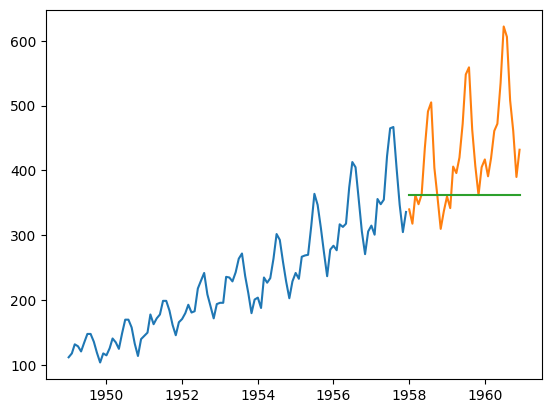

In [17]:
plt.plot(train_data )
plt.plot(test_data)
plt.plot(predicted_values['SES'] )
plt.show()

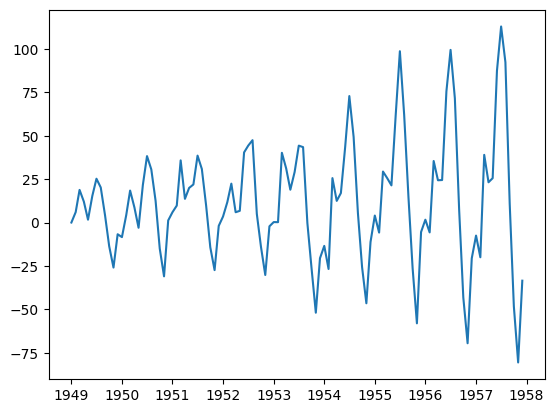

In [18]:
plt.plot(ses_model.resid)
plt.show()

### Metrics

In [19]:
model_residuals = pd.DataFrame(index=['MSE','RMSE','MAE','MAPE'])

In [20]:
mse = mean_squared_error(test_data['Passengers'],predicted_values['SES'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['Passengers'],predicted_values['SES'])
mape = mean_absolute_percentage_error(test_data['Passengers'],predicted_values['SES'])
model_residuals['SES'] = [mse,rmse,mae,mape]
model_residuals

,SES
MSE,10434.395944
RMSE,102.148891
MAE,76.254204
MAPE,0.158813


### Double Exponential Smoothing

In [21]:
des_AddTrend = ExponentialSmoothing(train_data, trend='add').fit()
res = des_AddTrend.forecast(test_len)

In [22]:
predicted_values['DES_AddTrend'] = res.values

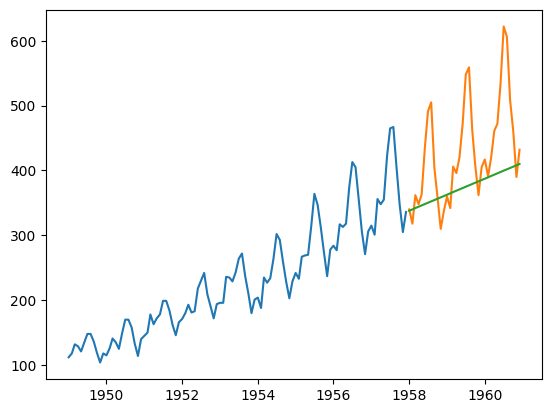

In [23]:
plt.plot(train_data )
plt.plot(test_data)
plt.plot(predicted_values['DES_AddTrend'] )
plt.show()

In [24]:
mse = mean_squared_error(test_data['Passengers'],predicted_values['DES_AddTrend'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['Passengers'],predicted_values['DES_AddTrend'])
mape = mean_absolute_percentage_error(test_data['Passengers'],predicted_values['DES_AddTrend'])
model_residuals['DES_AddTrend'] = [mse,rmse,mae,mape]
model_residuals

,SES,DES_AddTrend
MSE,10434.395944,7791.631326
RMSE,102.148891,88.270218
MAE,76.254204,63.343307
MAPE,0.158813,0.130924


In [25]:
des_MulTrend = ExponentialSmoothing(train_data, trend='mul').fit()
res = des_MulTrend.forecast(test_len)

In [26]:
predicted_values['DES_MulTrend'] = res.values

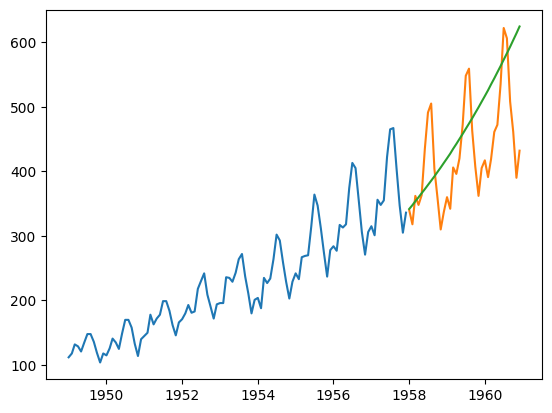

In [27]:
plt.plot(train_data )
plt.plot(test_data)
plt.plot(predicted_values['DES_MulTrend'] )
plt.show()

In [28]:
mse = mean_squared_error(test_data['Passengers'],predicted_values['DES_MulTrend'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['Passengers'],predicted_values['DES_MulTrend'])
mape = mean_absolute_percentage_error(test_data['Passengers'],predicted_values['DES_MulTrend'])
model_residuals['DES_MulTrend'] = [mse,rmse,mae,mape]
model_residuals

,SES,DES_AddTrend,DES_MulTrend
MSE,10434.395944,7791.631326,7982.134245
RMSE,102.148891,88.270218,89.342791
MAE,76.254204,63.343307,72.360522
MAPE,0.158813,0.130924,0.172538


### Triple Exponential Smoothing

In [29]:
TES_Additive = ExponentialSmoothing(train_data, trend='add', seasonal='add').fit()
res = TES_Additive.forecast(test_len)

In [30]:
predicted_values['TES_Additive'] = res.values

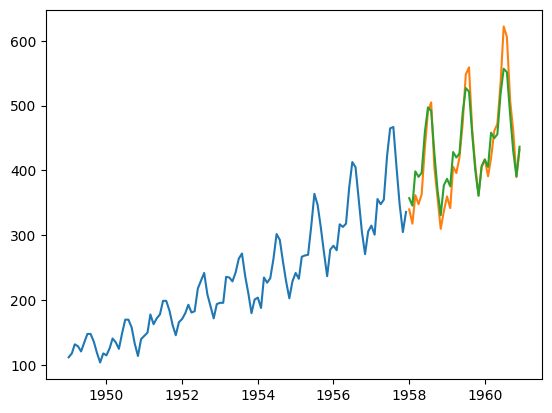

In [31]:
plt.plot(train_data )
plt.plot(test_data)
plt.plot(predicted_values['TES_Additive'] )
plt.show()

In [32]:
mse = mean_squared_error(test_data['Passengers'],predicted_values['TES_Additive'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['Passengers'],predicted_values['TES_Additive'])
mape = mean_absolute_percentage_error(test_data['Passengers'],predicted_values['TES_Additive'])
model_residuals['TES_Additive'] = [mse,rmse,mae,mape]
model_residuals

,SES,DES_AddTrend,DES_MulTrend,TES_Additive
MSE,10434.395944,7791.631326,7982.134245,695.691439
RMSE,102.148891,88.270218,89.342791,26.375963
MAE,76.254204,63.343307,72.360522,21.544968
MAPE,0.158813,0.130924,0.172538,0.051142


In [33]:
TES_Multiplicative = ExponentialSmoothing(train_data, trend='add', seasonal='mul').fit()
res = TES_Multiplicative.forecast(test_len)

In [34]:
predicted_values['TES_Multiplicative'] = res.values

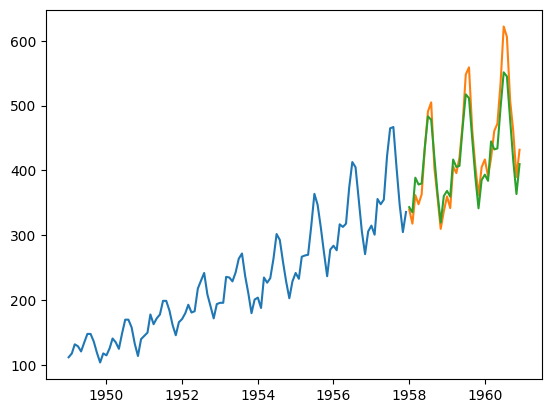

In [35]:
plt.plot(train_data )
plt.plot(test_data)
plt.plot(predicted_values['TES_Multiplicative'] )
plt.show()

In [36]:
mse = mean_squared_error(test_data['Passengers'],predicted_values['TES_Multiplicative'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['Passengers'],predicted_values['TES_Multiplicative'])
mape = mean_absolute_percentage_error(test_data['Passengers'],predicted_values['TES_Multiplicative'])
model_residuals['TES_Multiplicative'] = [mse,rmse,mae,mape]
model_residuals

,SES,DES_AddTrend,DES_MulTrend,TES_Additive,TES_Multiplicative
MSE,10434.395944,7791.631326,7982.134245,695.691439,749.028063
RMSE,102.148891,88.270218,89.342791,26.375963,27.368377
MAE,76.254204,63.343307,72.360522,21.544968,22.629295
MAPE,0.158813,0.130924,0.172538,0.051142,0.050689


### Rebuild the model with the entire data

In [37]:
TES_Additive_Fin = ExponentialSmoothing(data, trend='add', seasonal='add').fit()
res = TES_Additive_Fin.forecast(test_len)

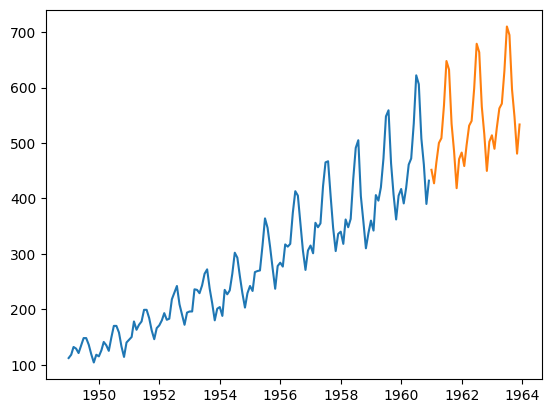

In [38]:
plt.plot(data)
plt.plot(res)
plt.show()

In [39]:
TES_Additive_Fin.resid.mean()

-0.0010763569341304526

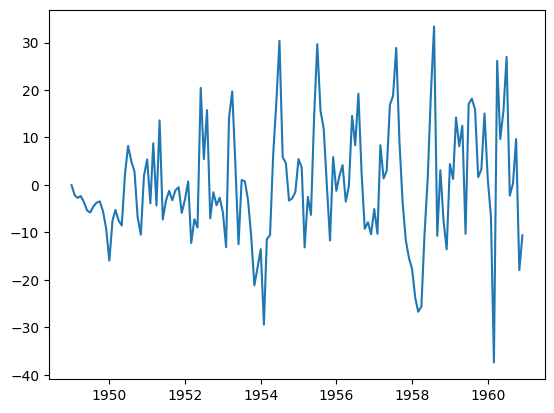

In [40]:
plt.plot(TES_Additive_Fin.resid)
plt.show()

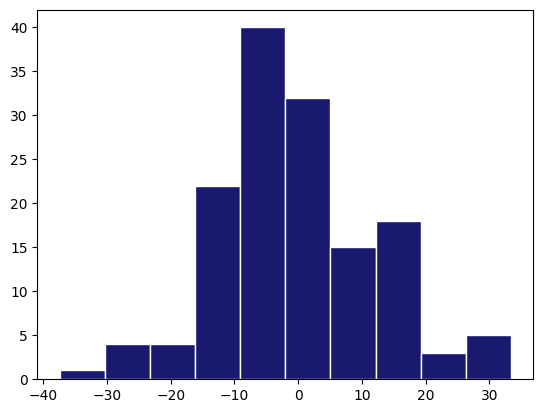

In [41]:
plt.hist(TES_Additive_Fin.resid, color = 'midnightblue', edgecolor='w')
plt.show()

In [42]:
TES_Multiplicative_Fin = ExponentialSmoothing(data, trend='add', seasonal='mul').fit()
res = TES_Multiplicative_Fin.forecast(test_len)

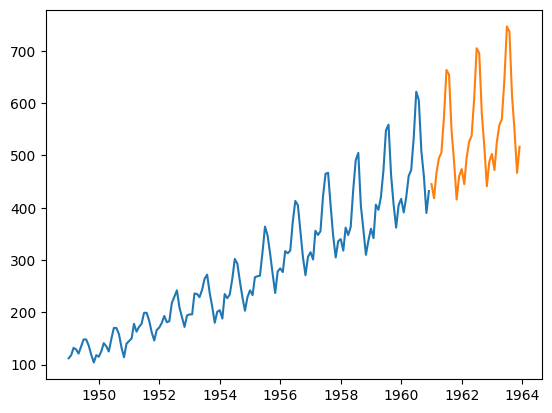

In [43]:
plt.plot(data)
plt.plot(res)
plt.show()

In [44]:
TES_Multiplicative_Fin.resid.mean()

-0.026356714500825145

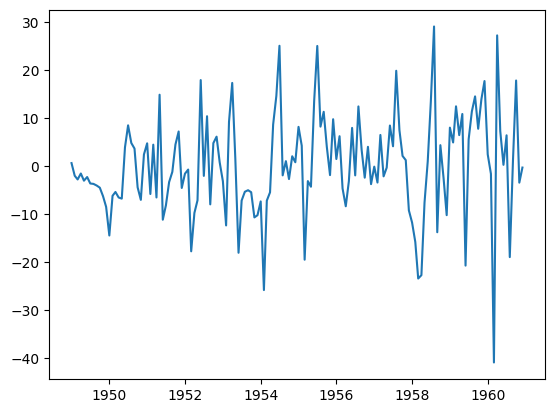

In [45]:
plt.plot(TES_Multiplicative_Fin.resid)
plt.show()

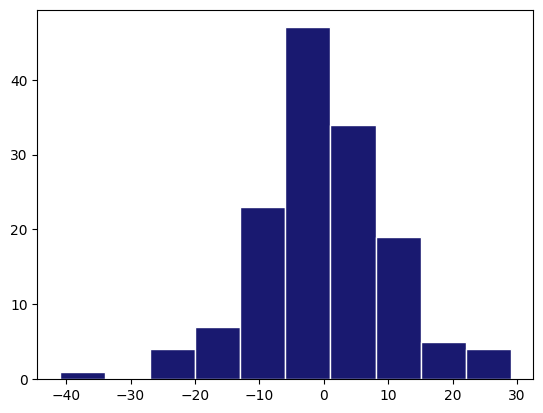

In [46]:
plt.hist(TES_Multiplicative_Fin.resid, color = 'midnightblue', edgecolor='w')
plt.show()